# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for L in range(len(learning_rates)):
    for R in range(len(regularization_strengths)):
        SM_classifier = Softmax()
        SM_classifier.train(X_train_feats,y_train,learning_rate=learning_rates[L],
                                             reg=regularization_strengths[R])
        y_pred = SM_classifier.predict(X_train_feats)
        train_accuracy = np.mean(y_pred == y_train)
        
        y_pred = SM_classifier.predict(X_val_feats)
        val_accuracy = np.mean(y_pred == y_val)
        results[(learning_rates[L],regularization_strengths[R])]=(train_accuracy,val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = SM_classifier
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

cs231n/classifiers/softmax.py:79: RuntimeWarning: divide by zero encountered in log
  loss_vec = -1 * np.log (probabilites_of_classes[range(N),y])


lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.103755 val accuracy: 0.114000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.343265 val accuracy: 0.362000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.325878 val accuracy: 0.334000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.419204 val accuracy: 0.413000
lr 1.000000e-06 reg 1.000000e+06 train accuracy: 0.339469 val accuracy: 0.346000
lr 1.000000e-06 reg 1.000000e+07 train accuracy: 0.110184 val accuracy: 0.107000
lr 1.000000e-05 reg 1.000000e+05 train accuracy: 0.319408 val accuracy: 0.315000
lr 1.000000e-05 reg 1.000000e+06 train accuracy: 0.131429 val accuracy: 0.133000
lr 1.000000e-05 reg 1.000000e+07 train accuracy: 0.125959 val accuracy: 0.148000
best validation accuracy achieved during cross-validation: 0.413000


cs231n/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
cs231n/classifiers/softmax.py:89: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


In [6]:
best_softmax.train(X_train_feats,y_train,learning_rate=1e-6,reg=1e5,num_iters=10000,verbose=True)


# Evaluate your trained SVM on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

iteration 0 / 10000: loss 2.302584
iteration 100 / 10000: loss 2.302582
iteration 200 / 10000: loss 2.302583
iteration 300 / 10000: loss 2.302582
iteration 400 / 10000: loss 2.302582
iteration 500 / 10000: loss 2.302581
iteration 600 / 10000: loss 2.302582
iteration 700 / 10000: loss 2.302582
iteration 800 / 10000: loss 2.302582
iteration 900 / 10000: loss 2.302582
iteration 1000 / 10000: loss 2.302582
iteration 1100 / 10000: loss 2.302582
iteration 1200 / 10000: loss 2.302581
iteration 1300 / 10000: loss 2.302582
iteration 1400 / 10000: loss 2.302581
iteration 1500 / 10000: loss 2.302582
iteration 1600 / 10000: loss 2.302581
iteration 1700 / 10000: loss 2.302582
iteration 1800 / 10000: loss 2.302581
iteration 1900 / 10000: loss 2.302582
iteration 2000 / 10000: loss 2.302582
iteration 2100 / 10000: loss 2.302581
iteration 2200 / 10000: loss 2.302582
iteration 2300 / 10000: loss 2.302582
iteration 2400 / 10000: loss 2.302582
iteration 2500 / 10000: loss 2.302582
iteration 2600 / 10000: 

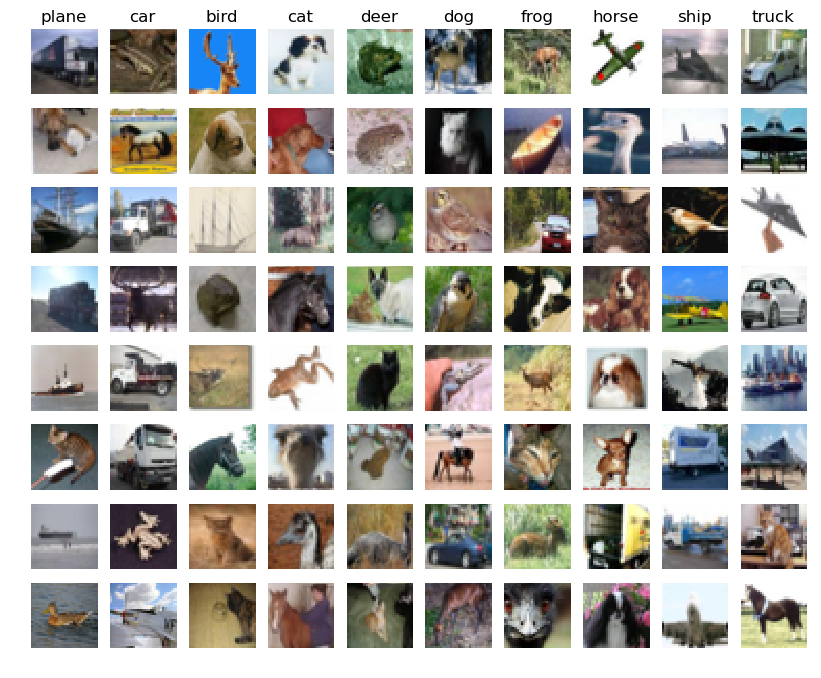

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
print X_train_feats.shape

(49000, 155)


In [15]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

results = {}
best_val = -1
learning_rates = np.logspace(-10,0,5)
regularization_strengths = np.logspace(-3,5,5) 
for L in learning_rates:
    for R in regularization_strengths:
        print "network has learning rate %e and Reg strength %e" % (L,R)
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        result = net.train(X_train_feats,y_train,X_val_feats, y_val,learning_rate=L,num_iters=1000, reg=R,verbose=True)
        results[(L,R)]=result
        if result['val_acc_history'][-1] > best_val:
            best_val = result['val_acc_history'][-1]
            best_net = net
print "finish cross validation stage with best net accuracy = ", best_val
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

network has learning rate 1.000000e-10 and Reg strength 1.000000e-03
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302585
iteration 200 / 1000: loss 2.302586
iteration 300 / 1000: loss 2.302585
iteration 400 / 1000: loss 2.302586
iteration 500 / 1000: loss 2.302585
iteration 600 / 1000: loss 2.302585
iteration 700 / 1000: loss 2.302586
iteration 800 / 1000: loss 2.302586
iteration 900 / 1000: loss 2.302586
network has learning rate 1.000000e-10 and Reg strength 1.000000e-01
iteration 0 / 1000: loss 2.302626
iteration 100 / 1000: loss 2.302626
iteration 200 / 1000: loss 2.302626
iteration 300 / 1000: loss 2.302626
iteration 400 / 1000: loss 2.302626
iteration 500 / 1000: loss 2.302626
iteration 600 / 1000: loss 2.302626
iteration 700 / 1000: loss 2.302626
iteration 800 / 1000: loss 2.302626
iteration 900 / 1000: loss 2.302626
network has learning rate 1.000000e-10 and Reg strength 1.000000e+01
iteration 0 / 1000: loss 2.306689
iteration 100 / 1000: loss 2.306688
iterati

In [ ]:
for net_params , result in results.iteritems():
    print net_params , result['val_acc_history'][-1] * 100

In [17]:
## Train Best Netwrok For longer time 

# Train the network
stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=1, learning_rate_decay=0.95,
            reg=1e-3, verbose=True)

iteration 0 / 10000: loss 1.714909
iteration 100 / 10000: loss 1.554604
iteration 200 / 10000: loss 1.535320
iteration 300 / 10000: loss 1.370556
iteration 400 / 10000: loss 1.332523
iteration 500 / 10000: loss 1.345280
iteration 600 / 10000: loss 1.312389
iteration 700 / 10000: loss 1.154188
iteration 800 / 10000: loss 1.043191
iteration 900 / 10000: loss 1.097618
iteration 1000 / 10000: loss 1.154119
iteration 1100 / 10000: loss 1.166832
iteration 1200 / 10000: loss 1.207177
iteration 1300 / 10000: loss 1.165191
iteration 1400 / 10000: loss 1.051355
iteration 1500 / 10000: loss 1.136715
iteration 1600 / 10000: loss 1.160701
iteration 1700 / 10000: loss 1.187647
iteration 1800 / 10000: loss 0.927436
iteration 1900 / 10000: loss 1.100493
iteration 2000 / 10000: loss 1.063018
iteration 2100 / 10000: loss 1.137468
iteration 2200 / 10000: loss 1.047314
iteration 2300 / 10000: loss 0.999955
iteration 2400 / 10000: loss 1.181459
iteration 2500 / 10000: loss 1.107281
iteration 2600 / 10000: 

In [20]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
y_test_pred = best_net.predict(X_test_feats)
test_acc = (y_test_pred == y_test).mean()
print test_acc

0.57


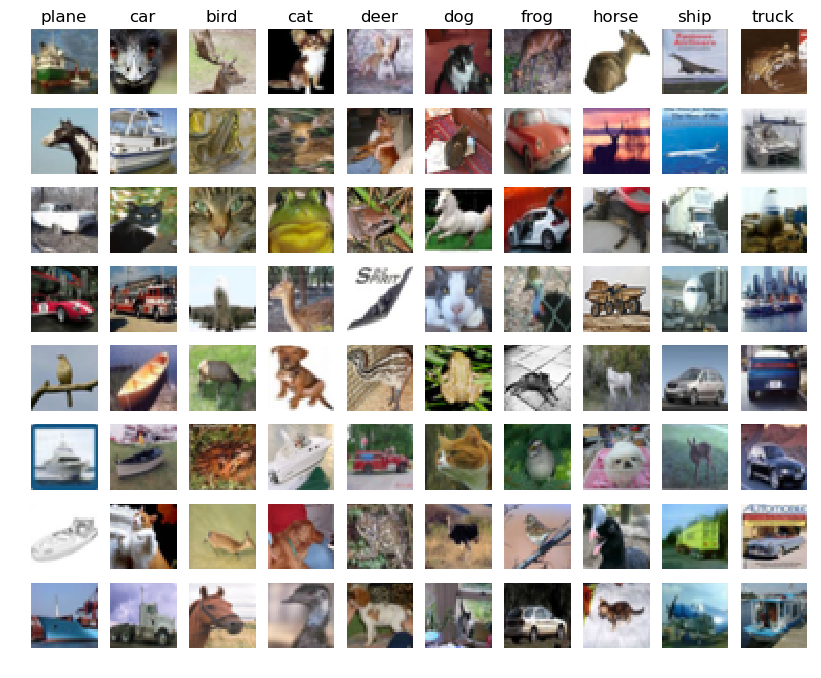

In [22]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
from cs231n.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
_, _, X_test_raw, y_test_raw = load_CIFAR10(cifar10_dir)

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        #print X_test[idx].reshape(32,32,3).shape
        plt.imshow((X_test_raw[idx].reshape(32,32,3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Confusion matrix, without normalization
[[60  1  6  2  5  2  2  2 18  5]
 [ 4 62  0  0  1  0  5  1  2 14]
 [11  1 48  9  7  6 10  5  3  0]
 [ 5  5  7 45  5 13 11  9  1  2]
 [ 1  0 10  3 47  4 10 10  2  3]
 [ 0  1 14 17  6 32  7  8  0  1]
 [ 0  1  7 11 13  3 74  1  1  1]
 [ 3  1  4  4  5  9  3 68  1  4]
 [24 10  1  2  1  0  3  0 60  5]
 [ 4 11  0  5  1  0  2  4  8 74]]
Normalized confusion matrix
[[ 0.58  0.01  0.06  0.02  0.05  0.02  0.02  0.02  0.17  0.05]
 [ 0.04  0.7   0.    0.    0.01  0.    0.06  0.01  0.02  0.16]
 [ 0.11  0.01  0.48  0.09  0.07  0.06  0.1   0.05  0.03  0.  ]
 [ 0.05  0.05  0.07  0.44  0.05  0.13  0.11  0.09  0.01  0.02]
 [ 0.01  0.    0.11  0.03  0.52  0.04  0.11  0.11  0.02  0.03]
 [ 0.    0.01  0.16  0.2   0.07  0.37  0.08  0.09  0.    0.01]
 [ 0.    0.01  0.06  0.1   0.12  0.03  0.66  0.01  0.01  0.01]
 [ 0.03  0.01  0.04  0.04  0.05  0.09  0.03  0.67  0.01  0.04]
 [ 0.23  0.09  0.01  0.02  0.01  0.    0.03  0.    0.57  0.05]
 [ 0.04  0.1   0.    0.05  0.01  0

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


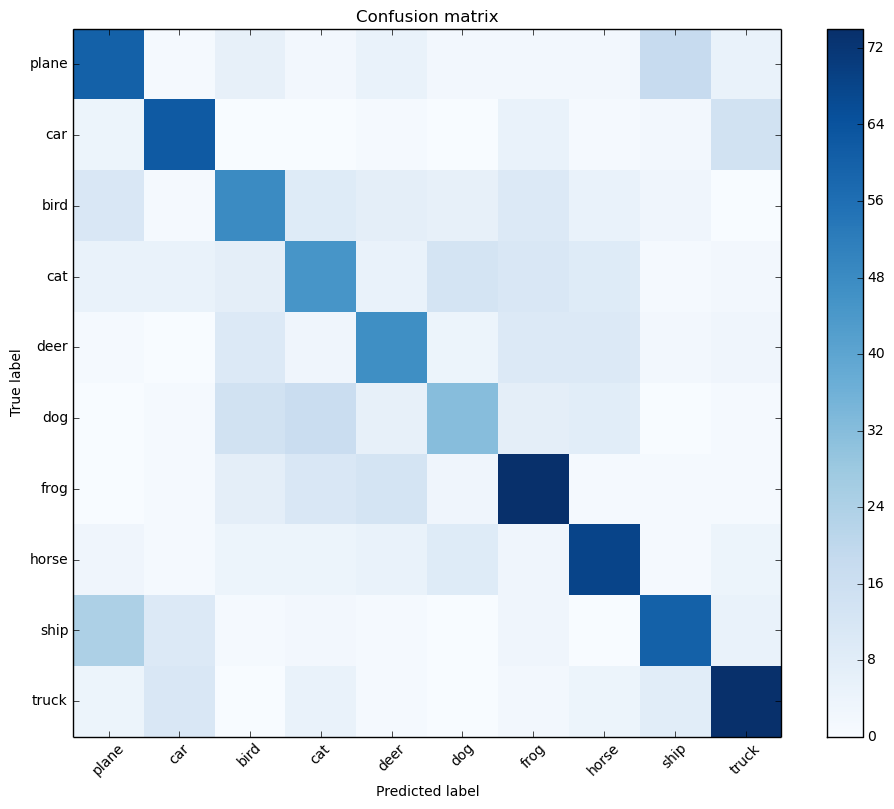

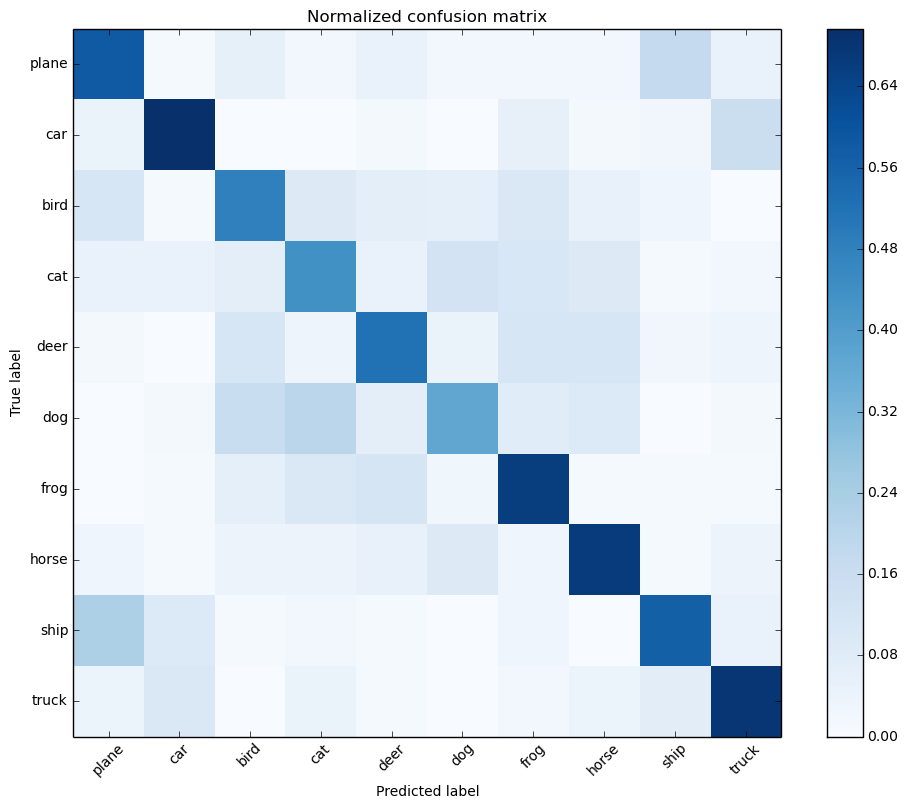

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!